# [AST: Audio Spectrogram Transformer](https://www.isca-speech.org/archive/interspeech_2021/gong21b_interspeech.html)

This colab script contains the implementation of a minimal demo of pretrained Audio Spectrogram Transformer (AST) inference and attention visualization.

This script is self-contained and can be run in one click, replace the `sample_audio_path` to test your own audio.

Please cite our paper if you find this repository useful.

```
@inproceedings{gong21b_interspeech,
  author={Yuan Gong and Yu-An Chung and James Glass},
  title={{AST: Audio Spectrogram Transformer}},
  year=2021,
  booktitle={Proc. Interspeech 2021},
  pages={571--575},
  doi={10.21437/Interspeech.2021-698}
}
```
For more information, please check https://github.com/YuanGongND/ast

## Step 1. Install and import required packages.

In [1]:
%cd ..

/home/milad/milad/1/TEZ/2sed-ast-3


In [2]:
# import sys
# if 'google.colab' in sys.modules:
#     print('Running in Colab.')
#     !git clone https://github.com/YuanGongND/ast
#     sys.path.append('./ast')
# #%cd ./ast/

# ! pip install timm==0.4.5
# ! pip install wget
import os, csv, argparse, wget
os.environ['TORCH_HOME'] = './ast/pretrained_models'
if os.path.exists('./ast/pretrained_models') == False:
  os.mkdir('./ast/pretrained_models')
import torch, torchaudio, timm
import numpy as np
from torch.cuda.amp import autocast
import IPython

In [3]:
!pip list

Package                  Version
------------------------ ----------
anyio                    3.6.2
argon2-cffi              21.3.0
argon2-cffi-bindings     21.2.0
arrow                    1.2.3
asttokens                2.2.1
attrs                    22.2.0
backcall                 0.2.0
beautifulsoup4           4.11.2
bleach                   6.0.0
certifi                  2022.12.7
cffi                     1.15.1
charset-normalizer       3.0.1
comm                     0.1.2
cycler                   0.11.0
debugpy                  1.6.6
decorator                5.1.1
defusedxml               0.7.1
executing                1.2.0
fastjsonschema           2.16.2
fqdn                     1.5.1
idna                     3.4
importlib-metadata       6.0.0
importlib-resources      5.12.0
ipykernel                6.21.2
ipython                  8.10.0
ipython-genutils         0.2.0
ipywidgets               8.0.4
isoduration              20.11.0
jedi                     0.18.2
Jinja2           

## Step 2. Create AST model and load AudioSet pretrained weights.
The pretrained model achieves 45.93 mAP on the AudioSet evaluation set, which is the best single model in the paper. 

In [4]:
%cd ./ast

/home/milad/milad/1/TEZ/2sed-ast-3/ast


In [5]:
ls

'AST_ Audio Spectrogram Transformer _ Papers With Code.pdf'
 AST_Inference_Demo_CPU.ipynb
 AST_Inference_Demo_CPU.py*
 AST_Inference_Demo_GPU.ipynb
 ast.png
 colab/
 egs/
 Installation.sh*
 LICENSE
 output.wav
 pretrained_models/
 README.md
 requirements.txt
 sample_audios/
 sound-16k.wav
 src/
 venv/


In [6]:
from src.models import ASTModel

# Create a new class that inherits the original ASTModel class
class ASTModelVis(ASTModel):
    def get_att_map(self, block, x):
        qkv = block.attn.qkv
        num_heads = block.attn.num_heads
        scale = block.attn.scale
        B, N, C = x.shape
        qkv = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn.softmax(dim=-1)
        return attn

    def forward_visualization(self, x):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        # save the attention map of each of 12 Transformer layer
        att_list = []
        for blk in self.v.blocks:
            cur_att = self.get_att_map(blk, x)
            att_list.append(cur_att)
            x = blk(x)
        return att_list

def make_features(wav_name, mel_bins, target_length=1024):
    waveform, sr = torchaudio.load(wav_name)
    assert sr == 16000, 'input audio sampling rate must be 16kHz'

    fbank = torchaudio.compliance.kaldi.fbank(
        waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
        window_type='hanning', num_mel_bins=mel_bins, dither=0.0, frame_shift=10)

    n_frames = fbank.shape[0]

    p = target_length - n_frames
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:target_length, :]

    fbank = (fbank - (-4.2677393)) / (4.5689974 * 2)
    return fbank


def load_label(label_csv):
    with open(label_csv, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        lines = list(reader)
    labels = []
    ids = []  # Each label has a unique id such as "/m/068hy"
    for i1 in range(1, len(lines)):
        id = lines[i1][1]
        label = lines[i1][2]
        ids.append(id)
        labels.append(label)
    return labels

# Create an AST model and download the AudioSet pretrained weights
audioset_mdl_url = 'https://www.dropbox.com/s/cv4knew8mvbrnvq/audioset_0.4593.pth?dl=1'
if os.path.exists('./pretrained_models/audio_mdl.pth') == False:
  wget.download(audioset_mdl_url, out='./pretrained_models/audio_mdl.pth')

# Assume each input spectrogram has 1024 time frames
input_tdim = 1024
checkpoint_path = './pretrained_models/audio_mdl.pth'
# now load the visualization model
ast_mdl = ASTModelVis(label_dim=527, input_tdim=input_tdim, imagenet_pretrain=False, audioset_pretrain=False)
print(f'[*INFO] load checkpoint: {checkpoint_path}')
checkpoint = torch.load(checkpoint_path, map_location='cpu')#'cuda')
audio_model = torch.nn.DataParallel(ast_mdl, device_ids=[0])
audio_model.load_state_dict(checkpoint)
audio_model = audio_model.to(torch.device('cpu'))#("cuda:0"))
audio_model.eval()          

# Load the AudioSet label set
label_csv = './egs/audioset/data/class_labels_indices.csv'       # label and indices for audioset data
labels = load_label(label_csv)

/home/milad/milad/1/TEZ/2sed-ast-3/ast/venv/lib/python3.8/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=1212
[*INFO] load checkpoint: ./pretrained_models/audio_mdl.pth


In [7]:
labels[:10], len(labels)

(['Speech',
  'Male speech, man speaking',
  'Female speech, woman speaking',
  'Child speech, kid speaking',
  'Conversation',
  'Narration, monologue',
  'Babbling',
  'Speech synthesizer',
  'Shout',
  'Bellow'],
 527)

In [8]:
print(audio_model)

DataParallel(
  (module): ASTModelVis(
    (v): DistilledVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (drop): Dropout(

## Step 3. Load an audio and predict the sound class.
By default we test one sample from another dataset (VGGSound) that has not been seen during the model training.

For this very specific sample, it is a parrot mimicing human speech and there's a bird chirp in the middle, that's why the model predicts it is a mixture of speech and bird sound. This audio is extracted from a Youtube video, and the video looks like this (note: only audio is used for prediction): 

Replace the `sample_audio_path` to test your own audio.

In [9]:
# ! sudo apt-get install sox 

In [18]:
# resampling data
! sox './sample_audios/2023-05-17-11:35:38.wav' -r 16000 './sample_audios/2023-05-17-11:35:38_16k.wav'

sox WARN wav: Premature EOF on .wav input file
sox WARN rate: rate clipped 742 samples; decrease volume?
sox WARN dither: dither clipped 682 samples; decrease volume?


In [22]:
path = './sample_audios/2023-05-17-11:35:38_16k.wav'

In [23]:
%%time
# Get a sample audio and make feature for predict
sample_path = path
feats = make_features(sample_path, mel_bins=128)           # shape(1024, 128)
feats_data = feats.expand(1, input_tdim, 128)           # reshape the feature
feats_data = feats_data.to(torch.device('cpu'))#("cuda:0"))
# do some masking of the input
#feats_data[:, :512, :] = 0.

# Make the prediction
with torch.no_grad():
  with autocast():
    output = audio_model.forward(feats_data)
    output = torch.sigmoid(output)
result_output = output.data.cpu().numpy()[0]
sorted_indexes = np.argsort(result_output)[::-1]

# Print audio tagging top probabilities
print('Predice results:')
for k in range(10):
    print('- {}: {:.4f}'.format(np.array(labels)[sorted_indexes[k]], result_output[sorted_indexes[k]]))
print('Listen to this sample: ')
IPython.display.Audio(sample_path)

/home/milad/milad/1/TEZ/2sed-ast-3/ast/venv/lib/python3.8/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Predice results:
- Pink noise: 0.4056
- Outside, rural or natural: 0.1664
- Bird: 0.0899
- Speech: 0.0459
- Chirp, tweet: 0.0367
- Animal: 0.0344
- Inside, small room: 0.0310
- Bird vocalization, bird call, bird song: 0.0301
- Squawk: 0.0226
- White noise: 0.0204
Listen to this sample: 
CPU times: user 6.87 s, sys: 1.13 s, total: 7.99 s
Wall time: 3.69 s


### check voice time series 

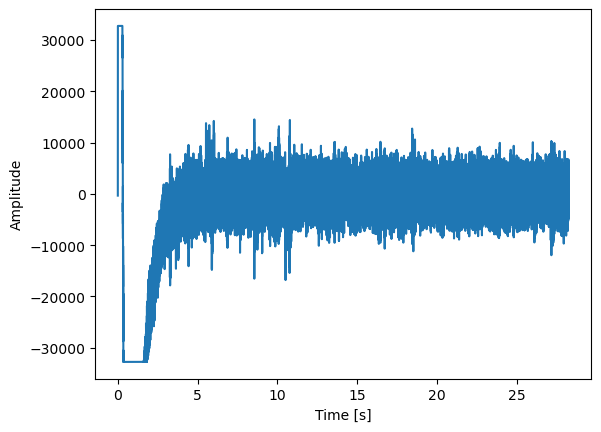

In [21]:
from scipy.io.wavfile import read #import the required function from the module
import matplotlib.pyplot as plt
import numpy as np

samplerate, data = read(sample_path)
duration = len(data)/samplerate

time = np.arange(0,duration,1/samplerate) #time vector

plt.plot(time,data)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()



### crop voice

In [33]:
import os

filename = sample_path
dirname = os.path.dirname(filename)
basename = os.path.basename(filename)
name_without_extension = os.path.splitext(basename)[0]

new_filename = os.path.join(dirname, f'{name_without_extension}_cropped.wav')

print(new_filename)

./sample_audios/clap_recorded4_16k_cropped.wav


In [34]:
from pydub import AudioSegment

# Load the audio file
audio = AudioSegment.from_file(sample_path)

# Set the start and end times for cropping (in milliseconds)
start_time = 4 * 1000  # Crop start time (1 second)
end_time = 5 * 1000    # Crop end time (5 seconds)

# Crop the audio
cropped_audio = audio[start_time:end_time]

# Export the cropped audio as a new file
cropped_audio.export(new_filename, format="wav")
IPython.display.Audio(new_filename)


Predice results:
- Pink noise: 0.3393
- White noise: 0.2260
- Static: 0.1179
- Rustling leaves: 0.0628
- Rustle: 0.0320
- Waterfall: 0.0190
- Silence: 0.0171
- Sound effect: 0.0142
- Music: 0.0122
- Speech: 0.0116
Execution time: 2.859318494796753 seconds




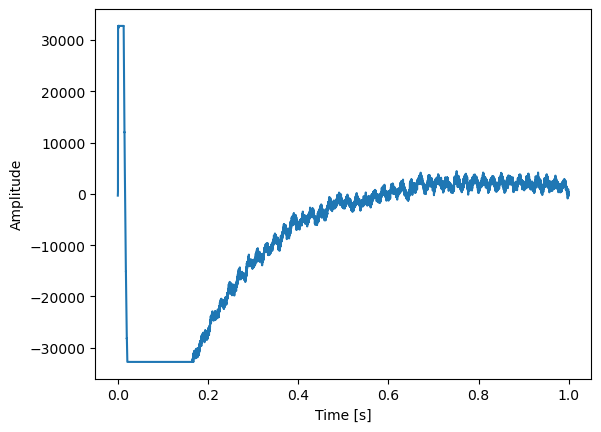

Predice results:
- Pink noise: 0.4202
- White noise: 0.1408
- Static: 0.0689
- Speech: 0.0490
- Rustle: 0.0448
- Rustling leaves: 0.0445
- Waterfall: 0.0329
- Music: 0.0276
- Vehicle: 0.0240
- Outside, rural or natural: 0.0218
Execution time: 2.94897723197937 seconds




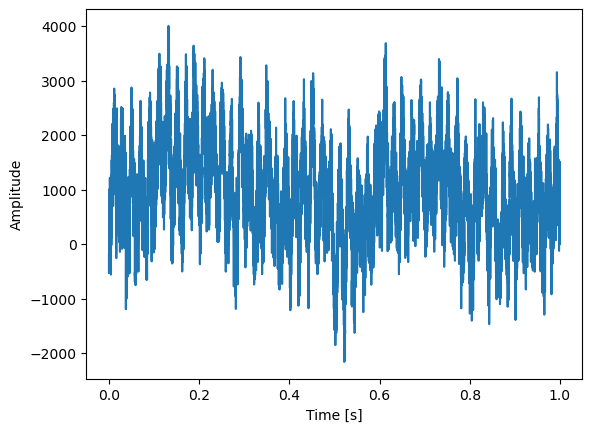

Predice results:
- Pink noise: 0.3885
- White noise: 0.1875
- Static: 0.1792
- Rustle: 0.0454
- Speech: 0.0353
- Rustling leaves: 0.0303
- Music: 0.0291
- Waterfall: 0.0232
- Sound effect: 0.0139
- Vehicle: 0.0138
Execution time: 2.99184250831604 seconds




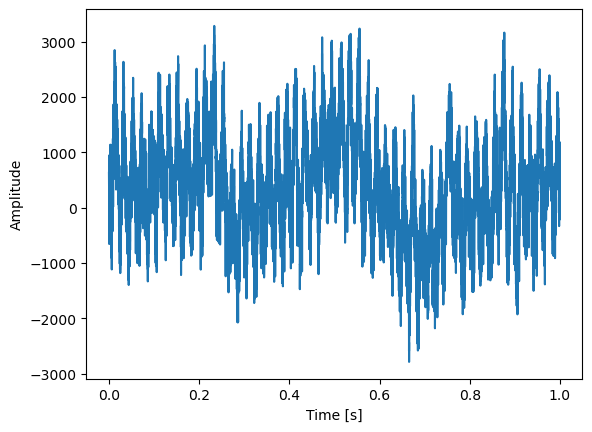

Predice results:
- Pink noise: 0.3382
- White noise: 0.1796
- Static: 0.1398
- Rustle: 0.0451
- Speech: 0.0367
- Rustling leaves: 0.0294
- Music: 0.0269
- Waterfall: 0.0218
- Vehicle: 0.0175
- Silence: 0.0125
Execution time: 2.9969234466552734 seconds




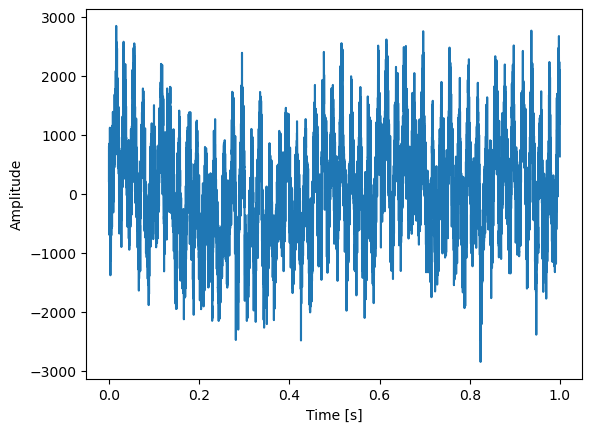

Predice results:
- Slap, smack: 0.4933
- Slam: 0.0736
- Tap: 0.0371
- Door: 0.0280
- Ping: 0.0250
- Whack, thwack: 0.0224
- Arrow: 0.0180
- Clapping: 0.0162
- Whip: 0.0107
- Bouncing: 0.0090
Execution time: 3.036099910736084 seconds




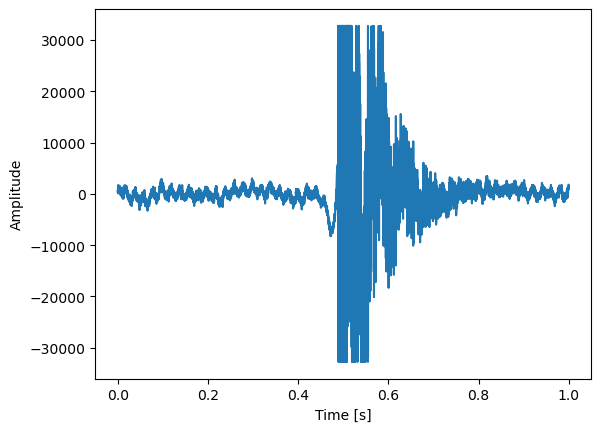

Predice results:
- Pink noise: 0.0890
- White noise: 0.0774
- Speech: 0.0532
- Rustle: 0.0474
- Rustling leaves: 0.0471
- Static: 0.0432
- Vehicle: 0.0366
- Music: 0.0287
- Animal: 0.0211
- Car: 0.0207
Execution time: 3.0249903202056885 seconds




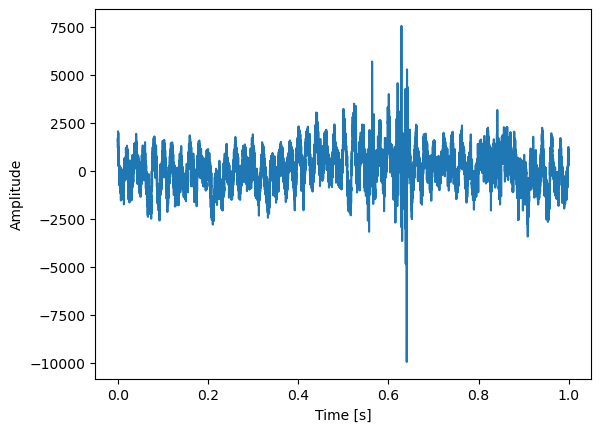

Predice results:
- Pink noise: 0.3471
- White noise: 0.1644
- Static: 0.1425
- Rustle: 0.0448
- Speech: 0.0430
- Music: 0.0320
- Rustling leaves: 0.0274
- Waterfall: 0.0229
- Vehicle: 0.0185
- Sound effect: 0.0138
Execution time: 2.9346182346343994 seconds




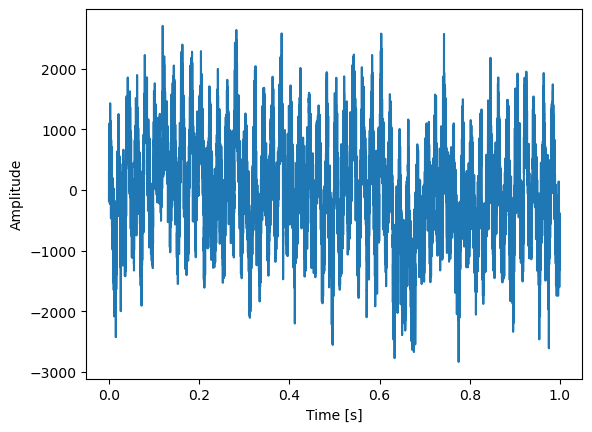

Predice results:
- Pink noise: 0.2953
- White noise: 0.1500
- Static: 0.0572
- Waterfall: 0.0516
- Speech: 0.0514
- Rustle: 0.0381
- Vehicle: 0.0295
- Music: 0.0288
- Rustling leaves: 0.0286
- Car: 0.0170
Execution time: 2.9665260314941406 seconds




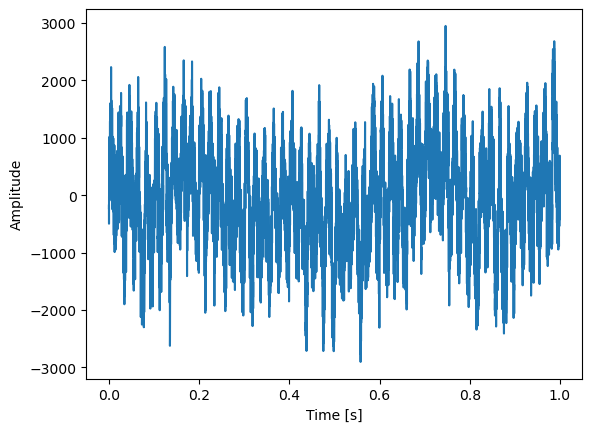

Predice results:
- Pink noise: 0.3218
- White noise: 0.1687
- Static: 0.1149
- Rustle: 0.0481
- Speech: 0.0445
- Rustling leaves: 0.0379
- Music: 0.0263
- Waterfall: 0.0250
- Vehicle: 0.0212
- Outside, rural or natural: 0.0136
Execution time: 3.0024397373199463 seconds




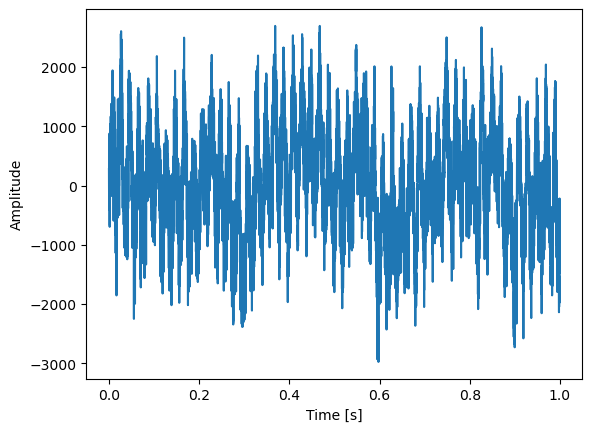

Predice results:
- Slap, smack: 0.1416
- Burst, pop: 0.1018
- Bang: 0.0706
- Explosion: 0.0657
- Firecracker: 0.0433
- Gunshot, gunfire: 0.0382
- Slam: 0.0190
- Whip: 0.0122
- Artillery fire: 0.0085
- Speech: 0.0082
Execution time: 3.0969111919403076 seconds




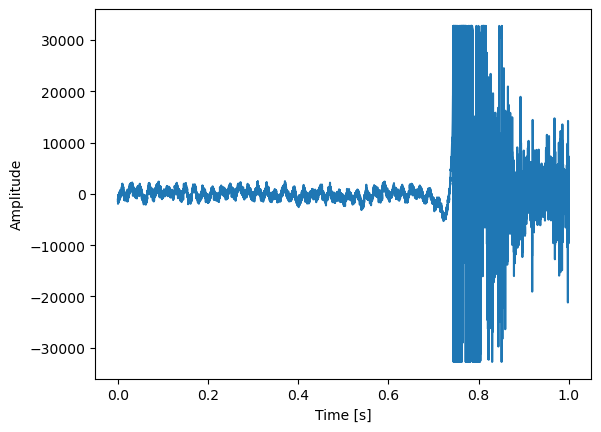

Predice results:
- Rustling leaves: 0.0569
- Wind noise (microphone): 0.0238
- Wind: 0.0208
- Crackle: 0.0201
- Vehicle: 0.0192
- Flap: 0.0178
- Static: 0.0159
- Explosion: 0.0159
- Rain on surface: 0.0153
- Eruption: 0.0137
Execution time: 2.930555582046509 seconds




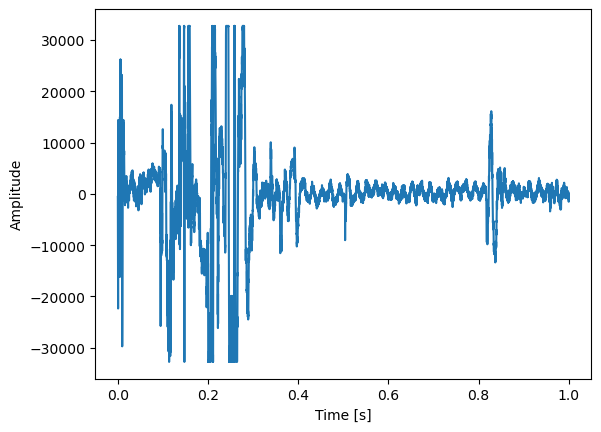

Predice results:
- Snort: 0.1182
- Gasp: 0.0525
- Speech: 0.0499
- Sneeze: 0.0457
- Wheeze: 0.0322
- Rustling leaves: 0.0205
- Pink noise: 0.0200
- Animal: 0.0185
- Rustle: 0.0164
- Sniff: 0.0162
Execution time: 2.9477157592773438 seconds




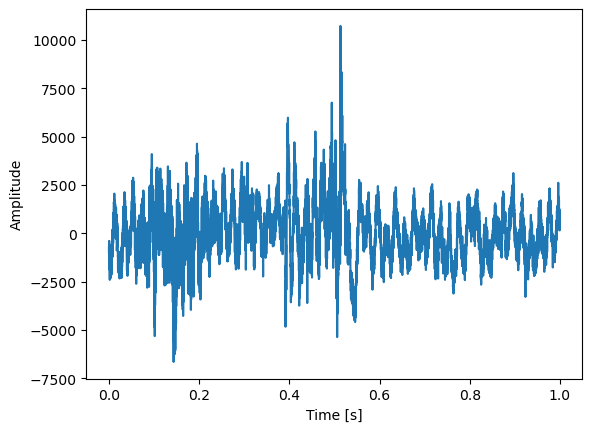

In [35]:
from pydub import AudioSegment
import time
from scipy.io.wavfile import read #import the required function from the module
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore", message="User provided device_type of 'cuda', but CUDA is not available. Disabling")

# Load the audio file
audio = AudioSegment.from_file(sample_path)

for i in range(12):
    # Set the start and end times for cropping (in milliseconds)
    start_time = i * 1000  # Crop start time (1 second)
    end_time = (i+1) * 1000    # Crop end time (5 seconds)

    # Crop the audio
    cropped_audio = audio[start_time:end_time]

    # Export the cropped audio as a new file
    cropped_audio.export(new_filename, format="wav")
    # IPython.display.Audio(new_filename)

    # %%time
    # Record the starting time
    start_time = time.time()

    # Get a sample audio and make feature for predict
    sample_path = new_filename
    feats = make_features(sample_path, mel_bins=128)           # shape(1024, 128)
    feats_data = feats.expand(1, input_tdim, 128)           # reshape the feature
    feats_data = feats_data.to(torch.device('cpu'))#("cuda:0"))
    # do some masking of the input
    #feats_data[:, :512, :] = 0.

    # Make the prediction
    with torch.no_grad():
        with autocast():
            output = audio_model.forward(feats_data)
            output = torch.sigmoid(output)
    result_output = output.data.cpu().numpy()[0]
    sorted_indexes = np.argsort(result_output)[::-1]

    # Print audio tagging top probabilities
    print('Predice results:')
    for k in range(10):
        print('- {}: {:.4f}'.format(np.array(labels)[sorted_indexes[k]], result_output[sorted_indexes[k]]))

    # Record the ending time
    end_time = time.time()        
    # Calculate the execution time
    execution_time = end_time - start_time
    # Print the execution time
    print(f"Execution time: {execution_time} seconds")

    # print('Listen to this sample: ')
    # IPython.display.Audio(new_filename)
    print('\n')

    samplerate, data = read(new_filename)
    duration = len(data)/samplerate

    time1 = np.arange(0,duration,1/samplerate) #time vector

    plt.plot(time1,data)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.show()    


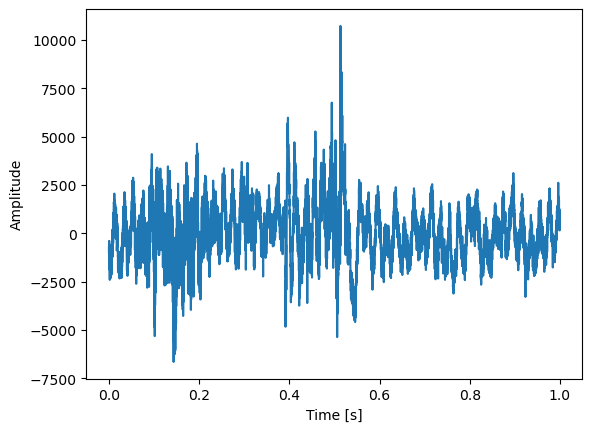

In [17]:
from scipy.io.wavfile import read #import the required function from the module
import matplotlib.pyplot as plt
import numpy as np

samplerate, data = read(new_filename)
duration = len(data)/samplerate

time = np.arange(0,duration,1/samplerate) #time vector

plt.plot(time,data)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

In [18]:
%%time
# Get a sample audio and make feature for predict
sample_path = new_filename
feats = make_features(sample_path, mel_bins=128)           # shape(1024, 128)
feats_data = feats.expand(1, input_tdim, 128)           # reshape the feature
feats_data = feats_data.to(torch.device('cpu'))#("cuda:0"))
# do some masking of the input
#feats_data[:, :512, :] = 0.

# Make the prediction
with torch.no_grad():
  with autocast():
    output = audio_model.forward(feats_data)
    output = torch.sigmoid(output)
result_output = output.data.cpu().numpy()[0]
sorted_indexes = np.argsort(result_output)[::-1]

# Print audio tagging top probabilities
print('Predice results:')
for k in range(10):
    print('- {}: {:.4f}'.format(np.array(labels)[sorted_indexes[k]], result_output[sorted_indexes[k]]))
print('Listen to this sample: ')
IPython.display.Audio(new_filename)

/home/milad/milad/1/TEZ/2sed-ast-3/ast/venv/lib/python3.8/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Predice results:
- Snort: 0.1182
- Gasp: 0.0525
- Speech: 0.0499
- Sneeze: 0.0457
- Wheeze: 0.0322
- Rustling leaves: 0.0205
- Pink noise: 0.0200
- Animal: 0.0185
- Rustle: 0.0164
- Sniff: 0.0162
Listen to this sample: 
CPU times: user 6.37 s, sys: 1.02 s, total: 7.38 s
Wall time: 2.73 s


### draw specs

In [22]:
# for data transformation
import numpy as np
# for visualizing the data
import matplotlib.pyplot as plt
# for opening the media file
import scipy.io.wavfile as wavfile
import os

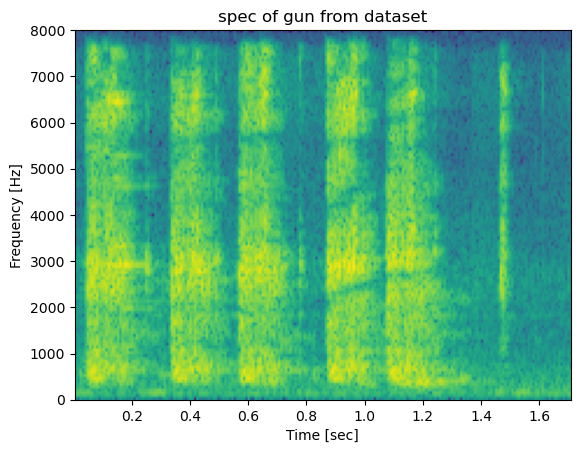

In [23]:
# mobile microphone
Fs, aud = wavfile.read('./sample_audios/voice_gun3_16k_croped.wav')
# select left channel only
# aud = aud[:,0]
# trim the first 125 seconds
first = aud[:int(Fs*125)]

powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(first, Fs=Fs)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("spec of gun from dataset")
plt.show()      

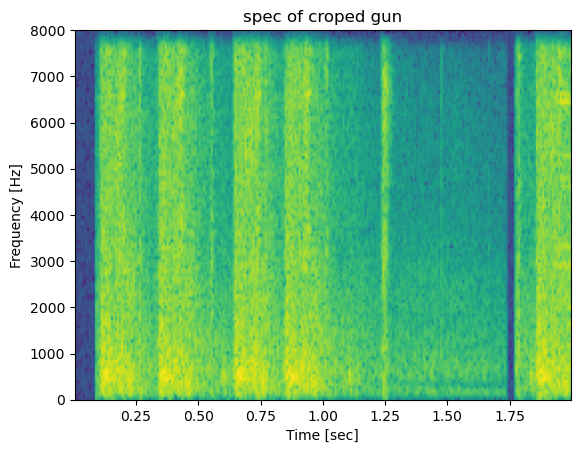

In [24]:
# high quality microphone
Fs, aud = wavfile.read('./sample_audios/gun_recorded_16k.wav')
# select left channel only
# aud = aud[:,0]
# trim the first 125 seconds
first = aud[:int(Fs*2)]

powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(first, Fs=Fs)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("spec of croped gun")
plt.show()      

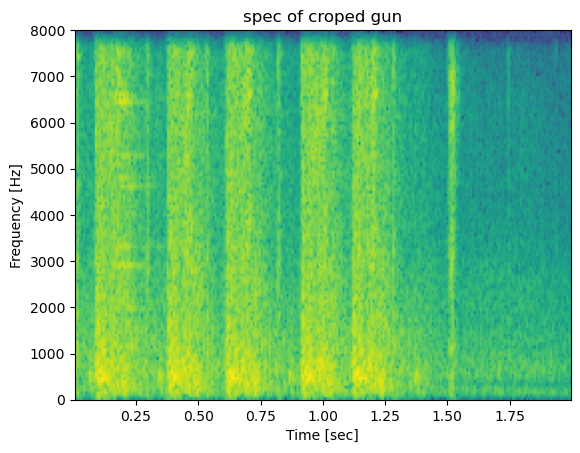

In [26]:
# original sound
Fs, aud = wavfile.read('./sample_audios/gun-17ak-16k.wav')
# select left channel only
aud = aud[:,0]
# trim the first 125 seconds
first = aud[:int(Fs*125)]

powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(first, Fs=Fs)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("spec of croped gun")
plt.show()      

## check model for voice

In [31]:
# Get a sample audio and make feature for predict
feats = make_features('./sample_audios/gun_recorded_16k.wav', mel_bins=128)           # shape(1024, 128)
feats_data = feats.expand(1, input_tdim, 128)           # reshape the feature
feats_data = feats_data.to(torch.device('cpu'))#("cuda:0"))

# do some masking of the input
#feats_data[:, :512, :] = 0.

# Make the prediction
with torch.no_grad():
  with autocast():
    output = audio_model.forward(feats_data)
    output = torch.sigmoid(output)
result_output = output.data.cpu().numpy()[0]
sorted_indexes = np.argsort(result_output)[::-1]

# Print audio tagging top probabilities
print('Predice results:')
for k in range(10):
    print('- {}: {:.4f}'.format(np.array(labels)[sorted_indexes[k]], result_output[sorted_indexes[k]]))
print('Listen to this sample: ')
IPython.display.Audio('./sample_audios/gun_recorded_16k.wav')

Predice results:
- Gunshot, gunfire: 0.4055
- Machine gun: 0.3846
- Clang: 0.0741
- Sound effect: 0.0532
- Ding: 0.0226
- Artillery fire: 0.0146
- Fusillade: 0.0088
- Cap gun: 0.0064
- Bang: 0.0057
- Outside, rural or natural: 0.0056
Listen to this sample: 


In [32]:
%%time
# Make the prediction
with torch.no_grad():
  with autocast():
    output = audio_model.forward(feats_data)
    output = torch.sigmoid(output)
result_output = output.data.cpu().numpy()[0]
sorted_indexes = np.argsort(result_output)[::-1]

# Print audio tagging top probabilities
print('Predice results:')
for k in range(1):
    print('- {}: {:.4f}'.format(np.array(labels)[sorted_indexes[k]], result_output[sorted_indexes[k]]))

Predice results:
- Gunshot, gunfire: 0.4055
CPU times: user 6.45 s, sys: 968 ms, total: 7.42 s
Wall time: 3.09 s


## Step 4.a. Visualize the mean attention map of all attention heads for each layer
Note the model focuses on the middle high frequency bird chirp as well as the low frequency speech.

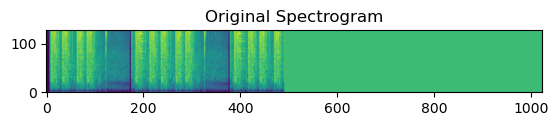

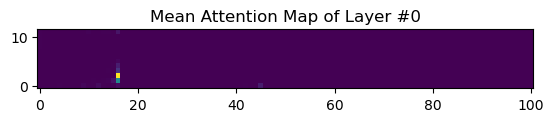

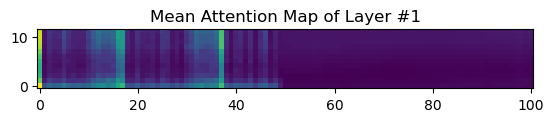

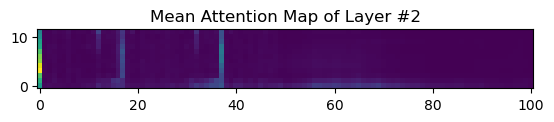

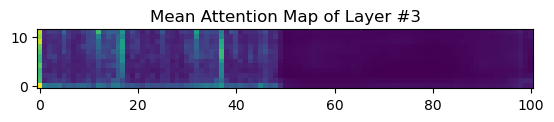

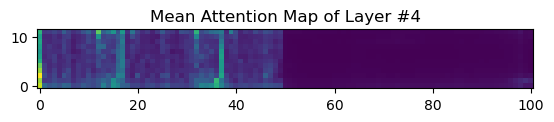

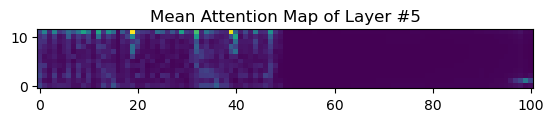

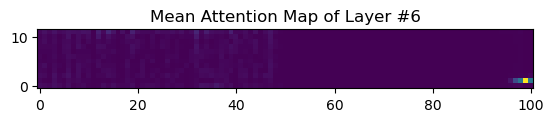

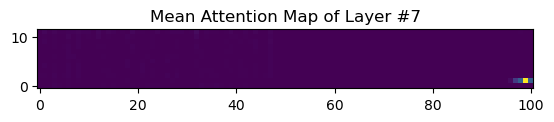

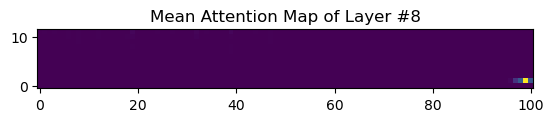

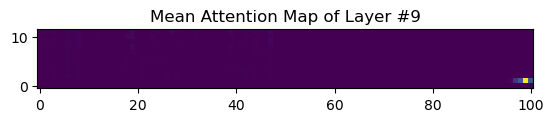

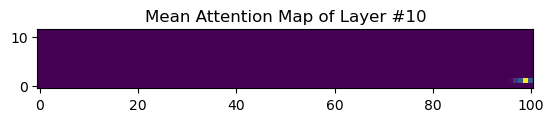

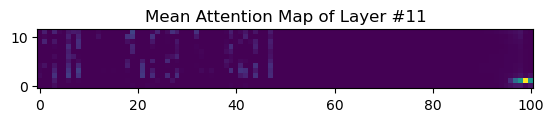

In [33]:
from matplotlib import pyplot as plt
plt.imshow(feats_data[0].t().cpu(), origin='lower')
plt.title('Original Spectrogram')
plt.show()
plt.close()
# Make the prediction
with torch.no_grad():
  with autocast():
    att_list = audio_model.module.forward_visualization(feats_data)
for i in range(len(att_list)):
  att_list[i] = att_list[i].data.cpu().numpy()
  att_list[i] = np.mean(att_list[i][0], axis=0)
  att_list[i] = np.mean(att_list[i][0:2], axis=0)
  att_list[i] = att_list[i][2:].reshape(12, 101)
  plt.imshow(att_list[i], origin='lower')
  plt.title('Mean Attention Map of Layer #{:d}'.format(i))
  plt.show()
  plt.close()

## Step 4.b. Visualize the attention map of each attention head of a specific layer
Note the attention map of heads are quite diverse.

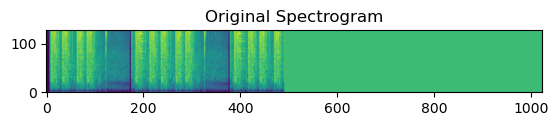

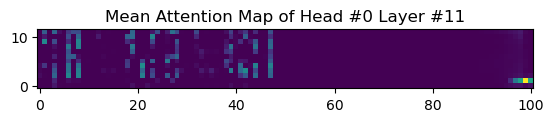

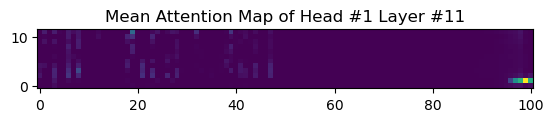

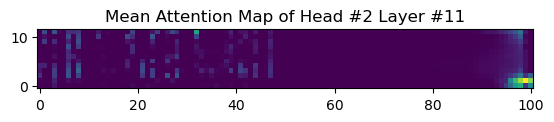

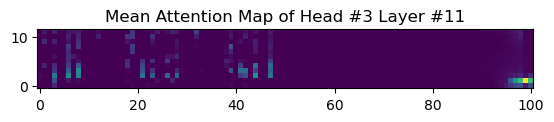

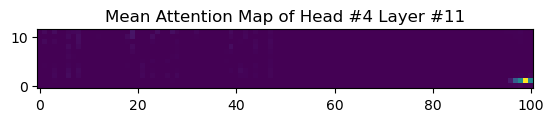

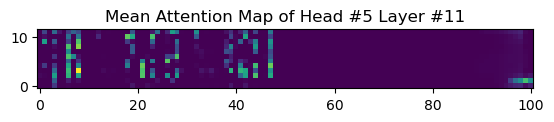

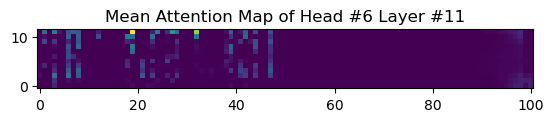

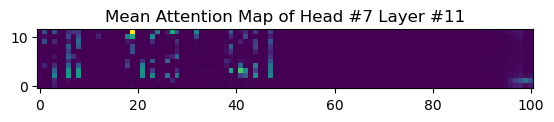

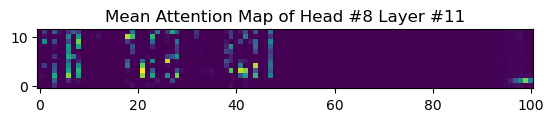

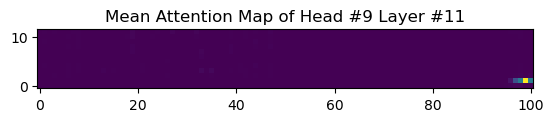

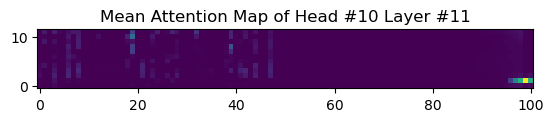

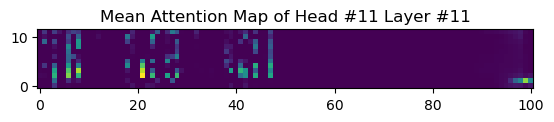

In [34]:
from matplotlib import pyplot as plt
plt.imshow(feats_data[0].t().cpu(), origin='lower')
plt.title('Original Spectrogram')
plt.show()
plt.close()
# Make the prediction
with torch.no_grad():
  with autocast():
    att_list = audio_model.module.forward_visualization(feats_data)

# the layer of interest
i = 11

att_map = att_list[i].data.cpu().numpy()
att_map = att_map[0]
att_map = np.mean(att_map[:, 0:2, :], axis=1)
att_map = att_map[:, 2:].reshape(12, 12, 101)
for j in range(12):
  plt.imshow(att_map[j], origin='lower')
  plt.title('Mean Attention Map of Head #{:d} Layer #{:d}'.format(j, i))
  plt.show()
  plt.close()